# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Data Loading and Cleaning

In [2]:
customer_file_url = "https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
customerdf = pd.read_csv(customer_file_url)
print(customerdf.head())

products_file_url = "https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0"
productsdf = pd.read_csv(products_file_url)
print(productsdf.head())

transactions_file_url = "https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"
transactionsdf = pd.read_csv(transactions_file_url)
print(transactionsdf.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [3]:
# Check for missing data and data types
def check_missing_data(df, name):
    print(f"--- {name} ---")
    print("Data Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\n")

check_missing_data(customerdf, "Customers")
check_missing_data(productsdf, "Products")
check_missing_data(transactionsdf, "Transactions")

--- Customers ---
Data Types:
 CustomerID      object
CustomerName    object
Region          object
SignupDate      object
dtype: object

Missing Values:
 CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64


--- Products ---
Data Types:
 ProductID       object
ProductName     object
Category        object
Price          float64
dtype: object

Missing Values:
 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64


--- Transactions ---
Data Types:
 TransactionID       object
CustomerID          object
ProductID           object
TransactionDate     object
Quantity             int64
TotalValue         float64
Price              float64
dtype: object

Missing Values:
 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64




In [4]:
# Summarize basic statistics
print("Customers Summary:\n", customerdf.describe(include='all'))
print("\nProducts Summary:\n", productsdf.describe(include='all'))
print("\nTransactions Summary:\n", transactionsdf.describe(include='all'))

Customers Summary:
        CustomerID      CustomerName         Region  SignupDate
count         200               200            200         200
unique        200               200              4         179
top         C0001  Lawrence Carroll  South America  2024-11-11
freq            1                 1             59           3

Products Summary:
        ProductID            ProductName Category       Price
count        100                    100      100  100.000000
unique       100                     66        4         NaN
top         P001  ActiveWear Smartwatch    Books         NaN
freq           1                      4       26         NaN
mean         NaN                    NaN      NaN  267.551700
std          NaN                    NaN      NaN  143.219383
min          NaN                    NaN      NaN   16.080000
25%          NaN                    NaN      NaN  147.767500
50%          NaN                    NaN      NaN  292.875000
75%          NaN                   

# Interesting Visualizations

## 1. Distribution of High-Value Customers by Region

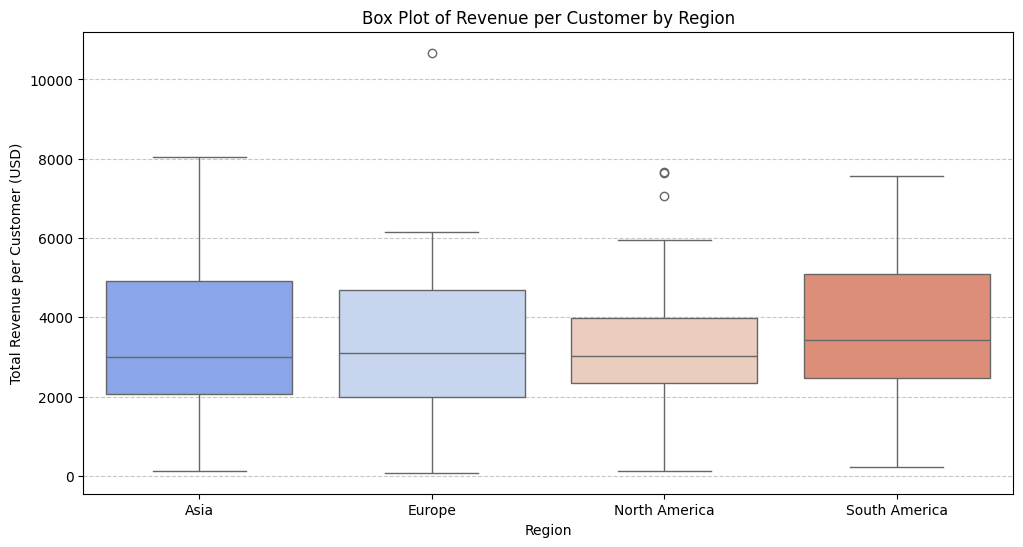

In [5]:
# Aggregate total revenue per customer by region
region_customer_revenue = transactionsdf.merge(customerdf, on='CustomerID').groupby(['Region', 'CustomerID'])['TotalValue'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(data=region_customer_revenue, x='Region', hue='Region', y='TotalValue', palette="coolwarm")
plt.title("Box Plot of Revenue per Customer by Region")
plt.xlabel("Region")
plt.ylabel("Total Revenue per Customer (USD)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 2. Region-Specific Product Demand

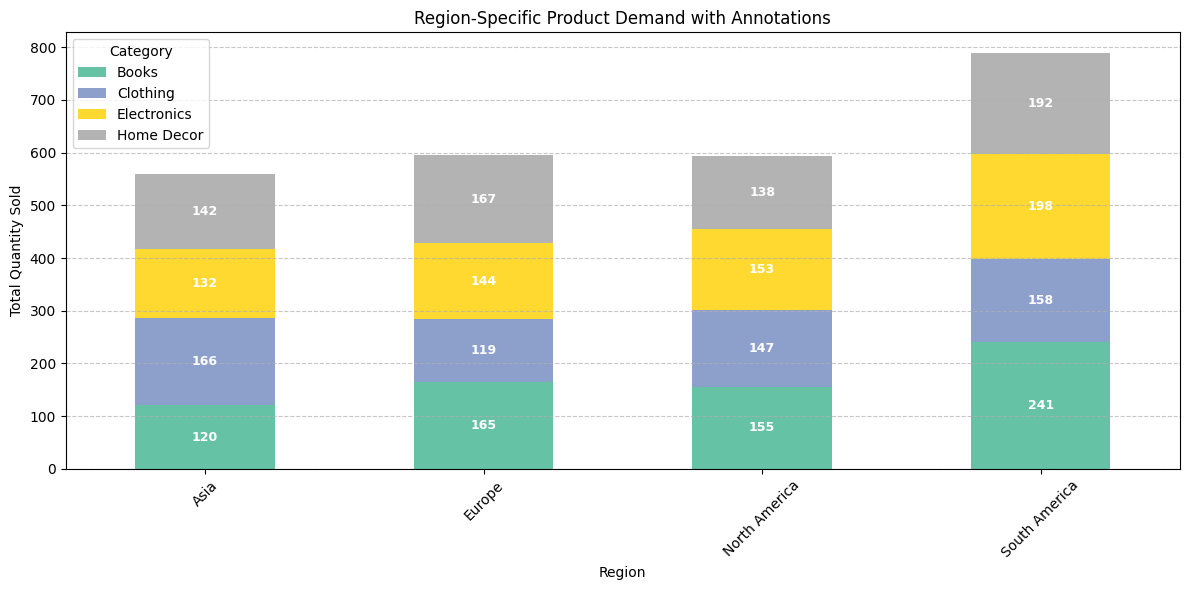

In [6]:
proddf = productsdf
region_category_sales = transactionsdf.merge(customerdf, on='CustomerID').merge(proddf, on='ProductID')
region_category_sales = region_category_sales.groupby(['Region', 'Category'])['Quantity'].sum().unstack()

fig, ax = plt.subplots(figsize=(12, 6))
bars = region_category_sales.plot(kind='bar', stacked=True, ax=ax, cmap="Set2")

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{int(height)}",
                ha="center", va="center", fontsize=9, color="white", fontweight="bold"
            )

plt.title("Region-Specific Product Demand with Annotations")
plt.xlabel("Region")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## 3. Time-Based Revenue Heatmap

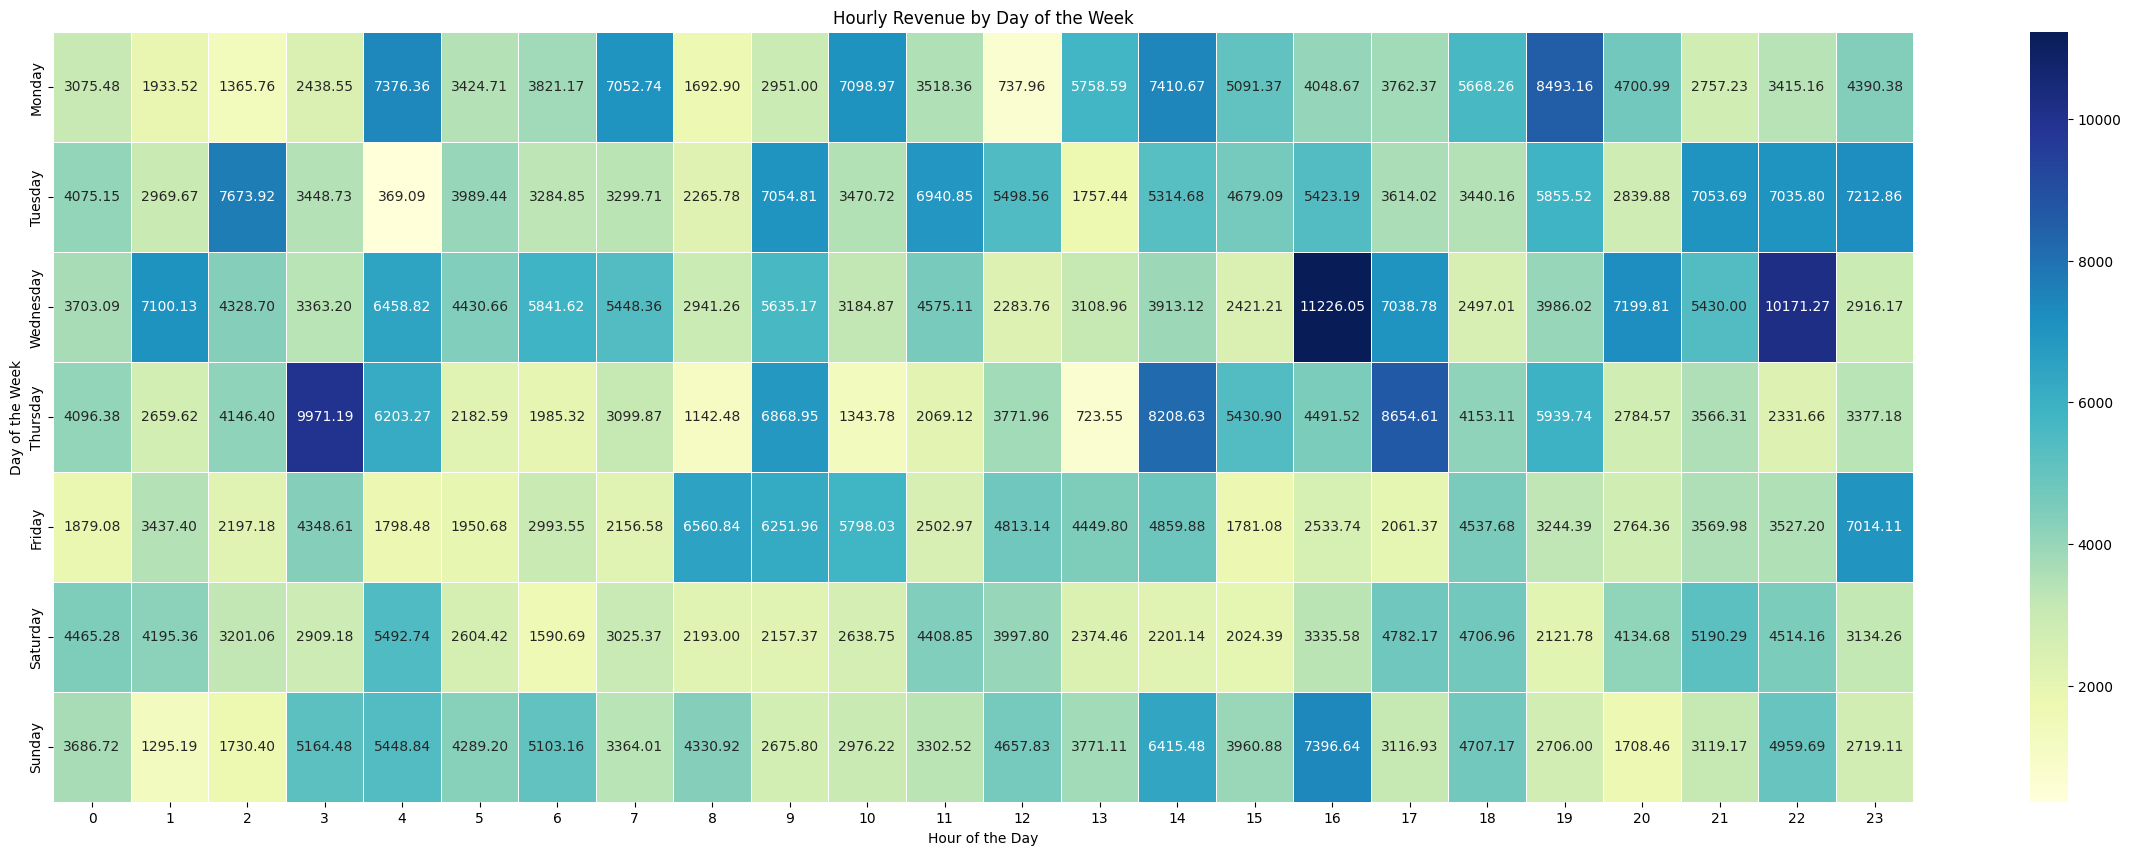

In [7]:
transactionsdf['TransactionDate'] = pd.to_datetime(transactionsdf['TransactionDate'], errors='coerce')

transactionsdf['Hour'] = transactionsdf['TransactionDate'].dt.hour
transactionsdf['DayOfWeek'] = transactionsdf['TransactionDate'].dt.day_name()

days_order = list(calendar.day_name)
transactionsdf['DayOfWeek'] = pd.Categorical(transactionsdf['DayOfWeek'], categories=days_order, ordered=True)

hourly_revenue = transactionsdf.pivot_table(index='DayOfWeek', columns='Hour', values='TotalValue', aggfunc='sum', observed=False)

plt.figure(figsize=(30, 10))
sns.heatmap(hourly_revenue, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Hourly Revenue by Day of the Week")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()

## Product Category Contribution over time

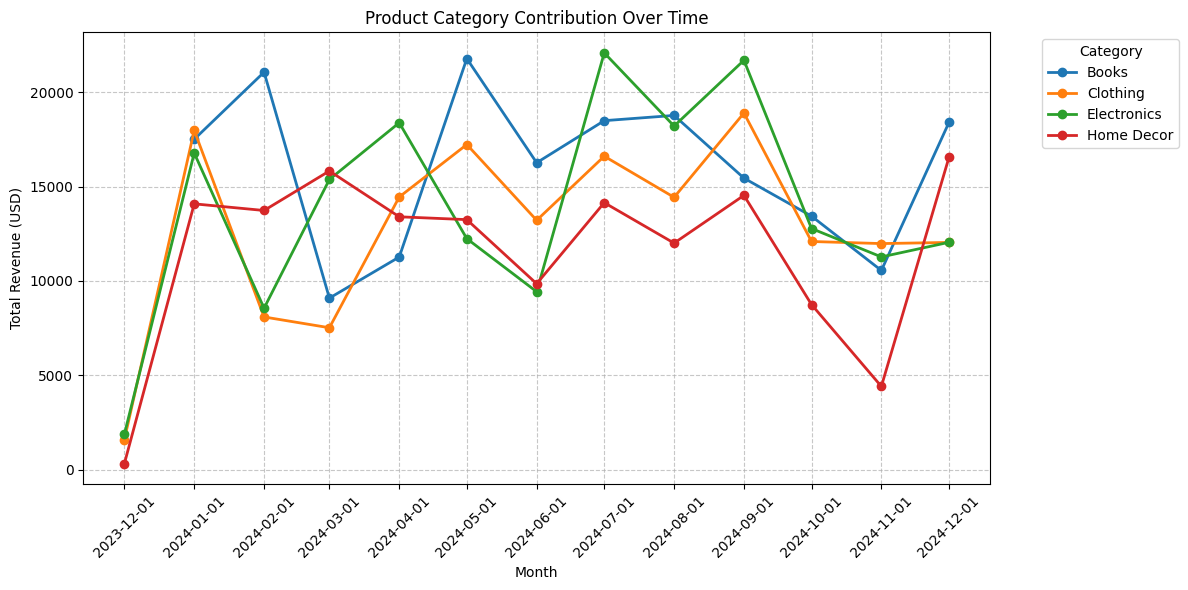

In [8]:
# Group data by TransactionDate and Category
category_revenue_time = transactionsdf.merge(productsdf, on='ProductID').groupby(
    [transactionsdf['TransactionDate'].dt.to_period('M'), 'Category']
)['TotalValue'].sum().unstack()

# Convert PeriodIndex to Timestamp for plotting
category_revenue_time.index = category_revenue_time.index.to_timestamp()

# Plot the line chart
plt.figure(figsize=(12, 6))
for category in category_revenue_time.columns:
    plt.plot(category_revenue_time.index, category_revenue_time[category], label=category, marker='o', linewidth=2)

# Ensure that all months show on the x-axis
plt.xticks(pd.date_range(start=category_revenue_time.index.min(), end=category_revenue_time.index.max(), freq='MS'), rotation=45)

# Formatting
plt.title("Product Category Contribution Over Time")
plt.xlabel("Month")
plt.ylabel("Total Revenue (USD)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Seasonality in transactions over time

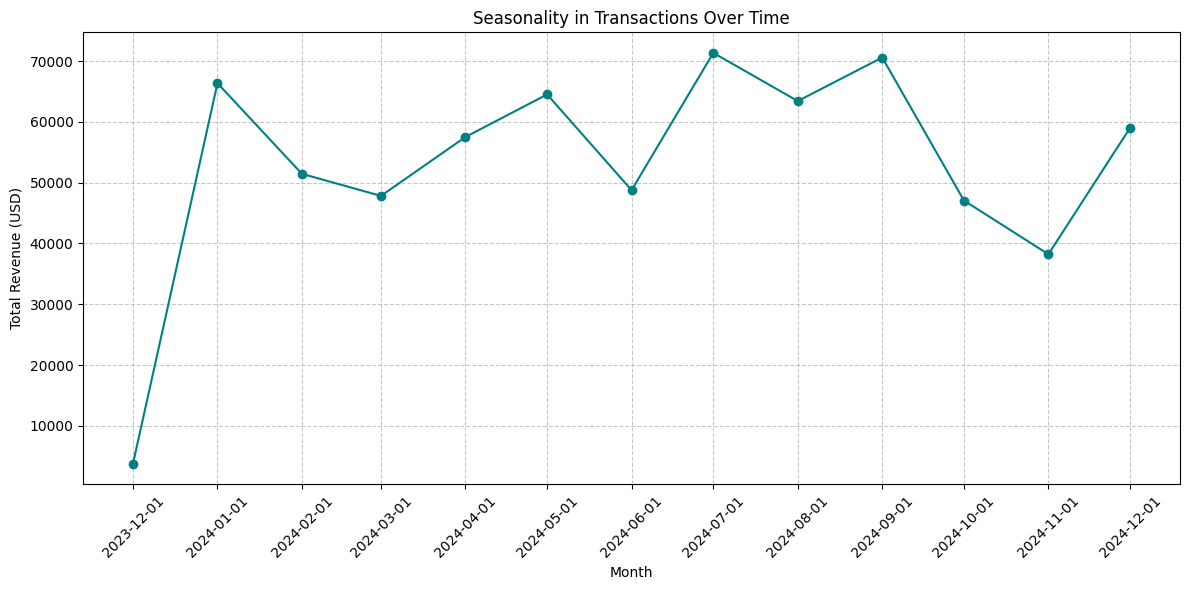

In [9]:
# Group data by year and month
seasonality = transactionsdf.groupby(transactionsdf['TransactionDate'].dt.to_period('M'))['TotalValue'].sum()

# Convert PeriodIndex to Timestamp for plotting
seasonality.index = seasonality.index.to_timestamp()

# Ensure all months are included, even if no data exists for some months
all_months = pd.date_range(start=seasonality.index.min(), end=seasonality.index.max(), freq='MS')

# Reindex the seasonality data to ensure all months are present
seasonality = seasonality.reindex(all_months, fill_value=0)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(seasonality.index, seasonality.values, marker='o', linestyle='-', color='teal')

# Title and labels
plt.title("Seasonality in Transactions Over Time")
plt.xlabel("Month")
plt.ylabel("Total Revenue (USD)")

# Format the x-axis to show all months
plt.xticks(all_months, rotation=45)

# Grid and layout
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Most purchased products

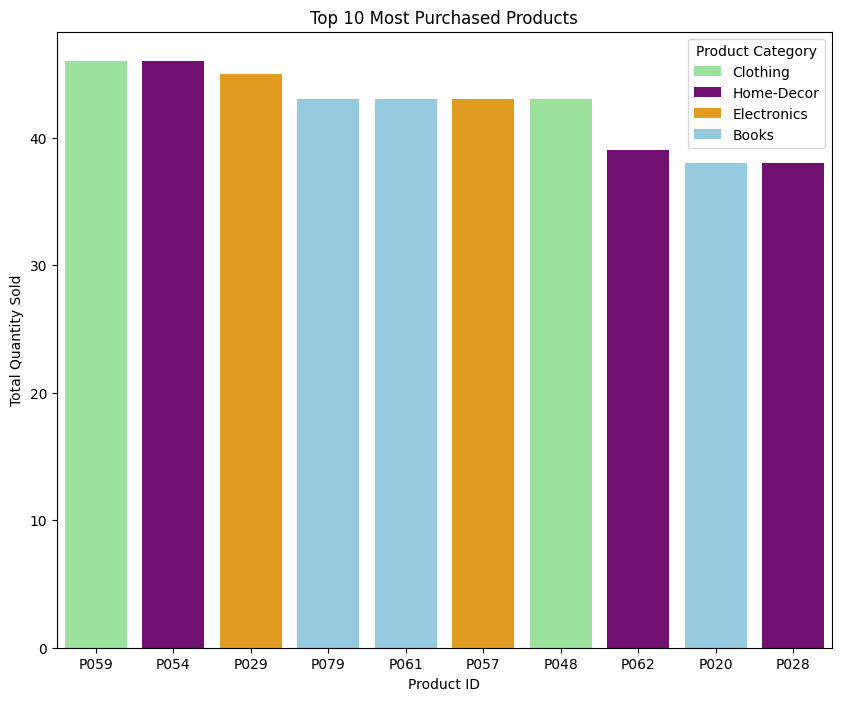

In [10]:
# Merge transactionsdf with products to get the categories
most_purchased = transactionsdf.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head(10)
most_purchased_products = productsdf[productsdf['ProductID'].isin(most_purchased.index)].copy()  # Avoid SettingWithCopyWarning

# Clean category names (if there's a mismatch like 'Home Decor' vs 'Home-Decor')
most_purchased_products['Category'] = most_purchased_products['Category'].replace({'Home Decor': 'Home-Decor'})

# Create a color mapping based on the product categories
category_color_map = {
    'Books': 'skyblue',
    'Clothing': 'lightgreen',
    'Electronics': 'orange',
    'Home-Decor': 'purple'
}

# Assign colors based on the categories
most_purchased_products['Color'] = most_purchased_products['Category'].map(category_color_map)

# Plot the top 10 most purchased products with the custom colors
plt.figure(figsize=(10, 8))
sns.barplot(x=most_purchased.index, y=most_purchased.values, hue=most_purchased_products['Category'],
            palette=category_color_map)
plt.title("Top 10 Most Purchased Products")
plt.xlabel("Product ID")
plt.ylabel("Total Quantity Sold")

# Add the legend
plt.legend(title='Product Category', loc='upper right')

plt.show()

# Additional Visualizations

## a. Count of customers per region

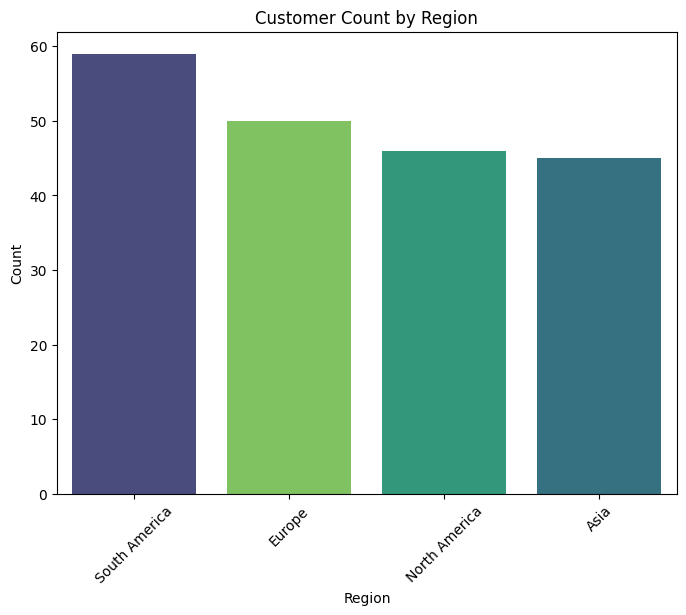

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(
    data=customerdf,
    x="Region",
    order=customerdf['Region'].value_counts().index,
    palette="viridis",
    hue="Region",
    legend=False
)
plt.title("Customer Count by Region")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## b. Revenue Contribution by Region

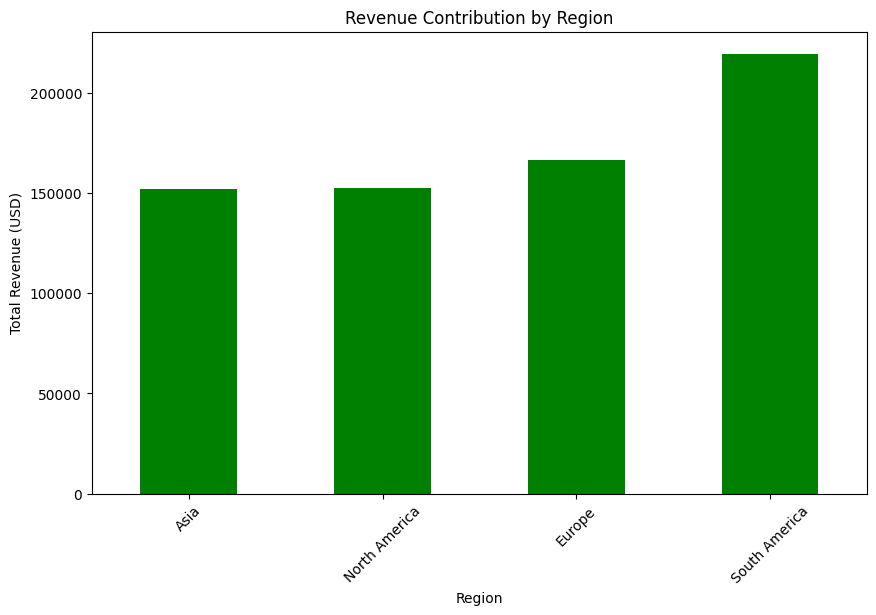

In [12]:
transactionsdf['TotalValue'] = pd.to_numeric(transactionsdf['TotalValue'], errors='coerce')
revenue_by_region = transactionsdf.merge(customerdf, on='CustomerID').groupby('Region')['TotalValue'].sum()

plt.figure(figsize=(10, 6))
revenue_by_region.sort_values().plot(kind='bar', color='green')
plt.title("Revenue Contribution by Region")
plt.xlabel("Region")
plt.ylabel("Total Revenue (USD)")
plt.xticks(rotation=45)
plt.show()

## c. Customer Signups Over Time

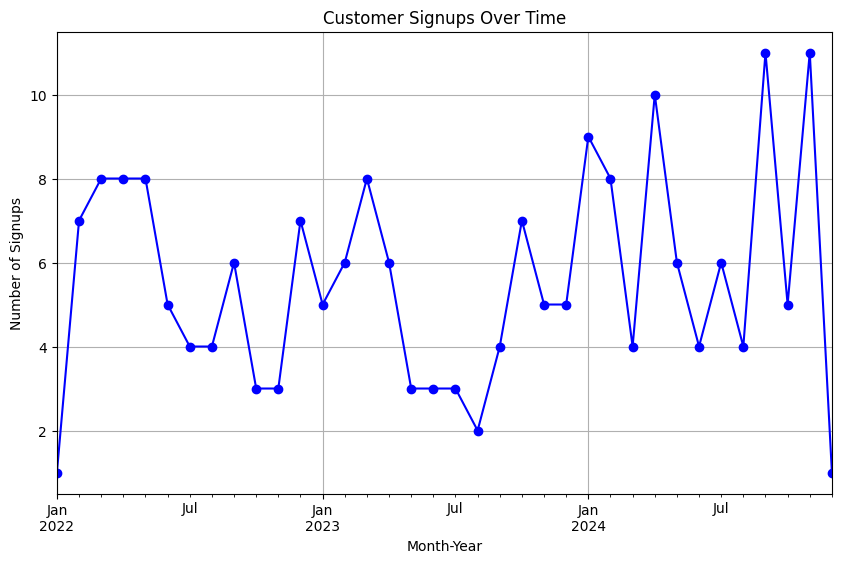

In [13]:
customerdf['SignupDate'] = pd.to_datetime(customerdf['SignupDate'])
signups_per_month = customerdf.groupby(customerdf['SignupDate'].dt.to_period('M')).size()

plt.figure(figsize=(10, 6))
signups_per_month.plot(kind='line', marker='o', color='blue')
plt.title("Customer Signups Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Number of Signups")
plt.grid()
plt.show()

## d. Category wise revenue

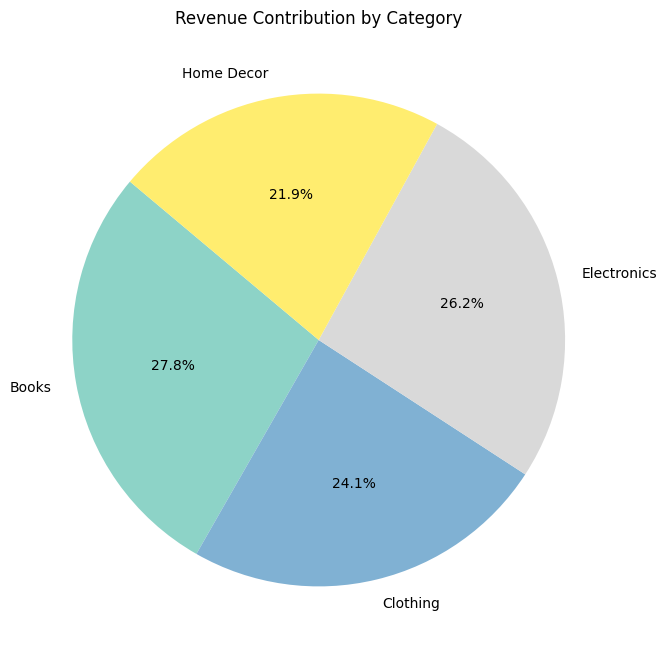

In [14]:
category_revenue = transactionsdf.merge(productsdf, on='ProductID').groupby('Category')['TotalValue'].sum()

plt.figure(figsize=(8, 8))
category_revenue.plot(kind='pie', autopct='%1.1f%%', startangle=140, cmap="Set3")
plt.title("Revenue Contribution by Category")
plt.ylabel("")  # Hides y-axis label
plt.show()

## e. Product Popularity by Region

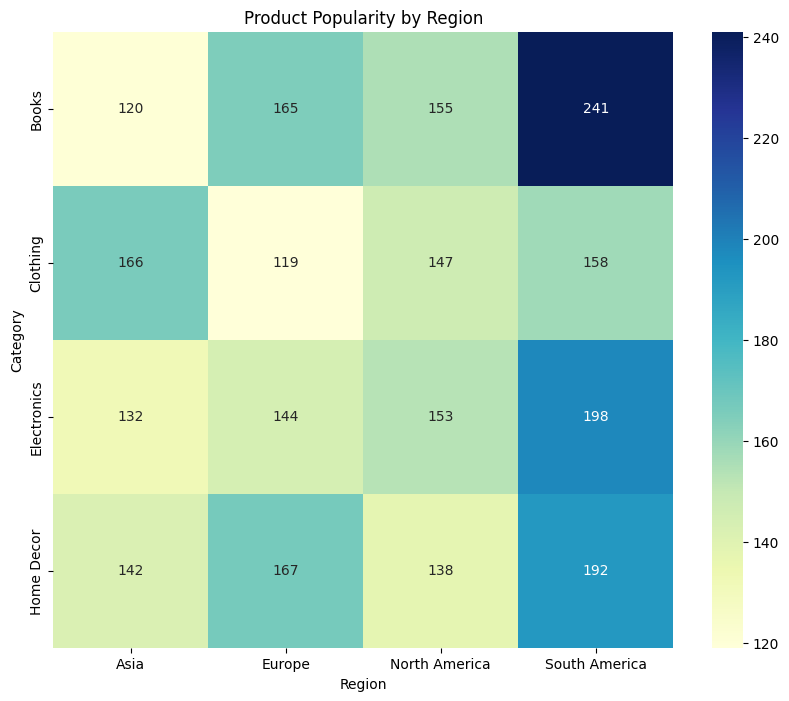

In [15]:
product_region = transactionsdf.merge(customerdf, on='CustomerID').merge(productsdf, on='ProductID')
heatmap_data = product_region.pivot_table(index='Category', columns='Region', values='Quantity', aggfunc='sum', fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="g")
plt.title("Product Popularity by Region")
plt.xlabel("Region")
plt.ylabel("Category")
plt.show()
